# Ni microspectrocopy data from BNL

In [1]:
from PIL import Image, ImageSequence
from ipywidgets import IntSlider, widgets, interactive, fixed
import itertools

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation, PillowWriter
import mplcursors
from matplotlib import gridspec
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import umap
from sklearn.manifold import TSNE

Missing reference data in HXN folder

In [2]:
def parse_tiff(filename):
    img = Image.open(filename)
    data = np.array(img)
    N = 0
    for i, page in enumerate(ImageSequence.Iterator(img)):
        N += 1
    Data = np.zeros((N, data.shape[0], data.shape[1]))
    for i, page in enumerate(ImageSequence.Iterator(img)):
        Data[i] = np.array(page)
    return Data

(101, 320, 320)
(73, 155, 160)


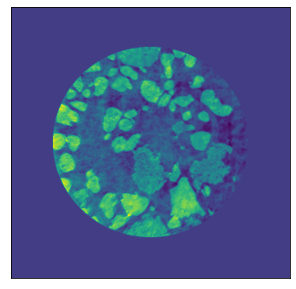

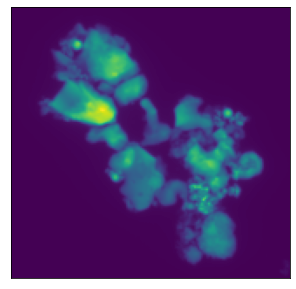

In [3]:
Ni_xanes = parse_tiff('Data/TXM_XANES/Ni_xanes.tiff')
Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')

def plot_img(data):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

print(Ni_xanes.shape)
print(Fe_xanes.shape)

plot_img(np.average(Ni_xanes, axis=0))
plot_img(np.average(Fe_xanes, axis=0))

In [4]:
def plot_spectra(i, Data):
    fig, ax = plt.subplots(figsize=(5, 5))    
    data = Data[i]
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        

data = Fe_xanes
slider = IntSlider(min=0, max=len(data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider, Data=fixed(data))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=72), Output()), _dom…

In [4]:
def remove_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

def add_point_label(pickable, data, ax):
    """Add point label."""
    def onselect(sel):
        x, y = sel.target.index[0], sel.target.index[1]
        annotation = f'({x}, {y})'
        sel.annotation.set_text(annotation)
        spectrum = data[:, x, y]
        ax.clear()
        ax.plot(np.arange(len(spectrum)), spectrum, linestyle='-', linewidth=2, c=plt.cm.tab10(7))
        remove_ticks(ax)
    mplcursors.cursor(pickable, highlight=True).connect("add", onselect)

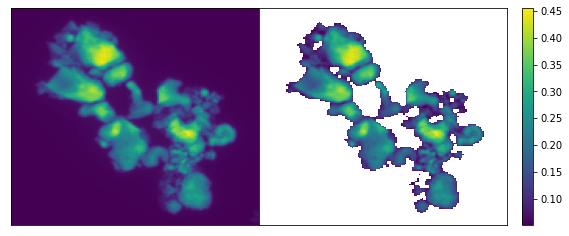

In [6]:
data = Fe_xanes

def get_filtered_img(data, threshold=0.05, return_mask=False):
    mask = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
    bool_arr = np.max(Fe_xanes, axis=0) < threshold
    mask[:, bool_arr] = 1
    filtered_img = np.ma.array(data, mask=mask)
    if return_mask:
        return filtered_img, mask
    else:
        return filtered_img

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')
ax = fig.add_subplot(spec[1])
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1], aspect='auto')

for ax in fig.get_axes():
    remove_ticks(ax)

plt.colorbar(img)
plt.show()

In [9]:
%matplotlib inline

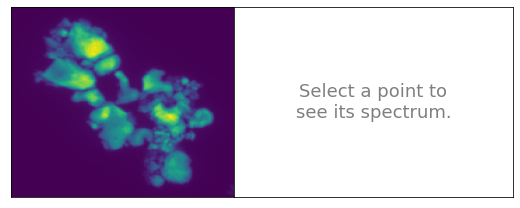

In [10]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

1. pca -> umap -> dbscan to cluster based on spectral similarity? Can this filter out background?
2. find spectral average for each cluster (excluding background) -> LCF -> same as expected results?

# PCA

In [11]:
def make_scree_plot(data, n=5, threshold=0.95, show_first_PC=True, mod=0, c=0):
    fig, ax = plt.subplots(figsize=(8,6))
    pca = PCA()
    pca_components = pca.fit_transform(data)

    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]

    ax.plot(x, cdf, 's-', markersize=10, fillstyle='none',
            color=plt.cm.tab10(c))
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

    if show_first_PC:
        PC1 = pca.components_[0]
        plt.plot(np.linspace(1, n, len(PC1)), -PC1*0.3 + min(cdf) + 0.05, 'k', linewidth=2)
        text = ax.text(n - 1, min(cdf) + 0.06, '$PC_1$', ha="right", va="bottom", size=20)

    if mod == 0:
        xticks = np.arange(n) + 1
    else:
        xticks = np.arange(0, n + 1, mod)
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(min(cdf) - 0.05, 1.02)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)

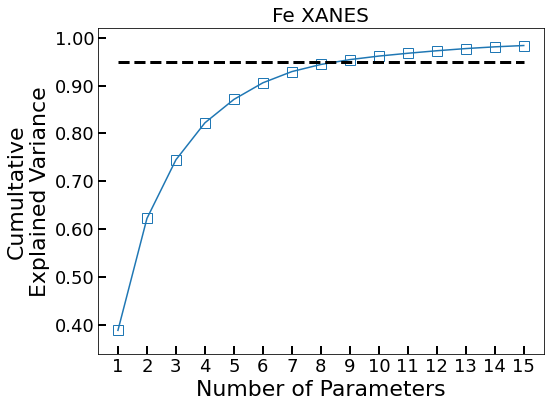

In [12]:
data = Fe_xanes.reshape(-1, len(Fe_xanes))
make_scree_plot(data, n=15, c=0, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.show()

# UMAP

In [96]:
data = Fe_xanes
fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

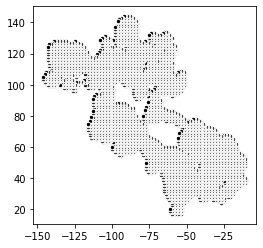

In [101]:
fig, ax = plt.subplots(figsize=(4, 4))
i = 0
for key in list(filtered_spectra_dict.keys()):
    x, y = key
    plt.scatter(-x, y, marker='o', c='k', s=20, edgecolor='w')
    i += 1
    print(i, end='\r')

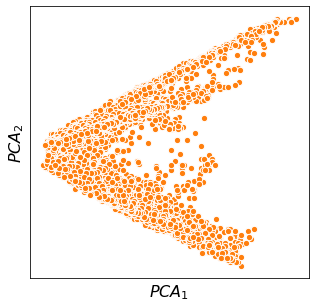

In [76]:
pca = PCA(n_components=10)
pca_components = pca.fit_transform(filtered_spectra)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], marker='o', s=40, 
            color=plt.cm.tab10(1), edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$PCA_1$', fontsize=16)
ax.set_ylabel('$PCA_2$', fontsize=16)
plt.show()

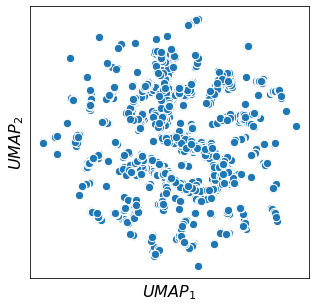

In [78]:
n_neighbors = 4
min_dist = 0.1
reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=n_neighbors, min_dist=min_dist)
reduced_space = reducer.fit_transform(pca_components)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=70, 
            color=plt.cm.tab10(0), edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$UMAP_1$', fontsize=16)
ax.set_ylabel('$UMAP_2$', fontsize=16)
plt.show()

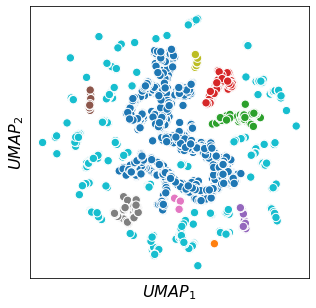

In [79]:
dbscan_clustering = DBSCAN(eps=1.3, min_samples=1).fit(reduced_space)
colors = [plt.cm.tab10(label) for label in dbscan_clustering.labels_]
cdict = {tup: colors[i] for i, tup in enumerate(list(filtered_spectra_dict.keys()))}

fig, ax = plt.subplots(figsize=(5, 5))
points = ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=70, 
                     color=colors, edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$UMAP_1$', fontsize=16)
ax.set_ylabel('$UMAP_2$', fontsize=16)
plt.show()

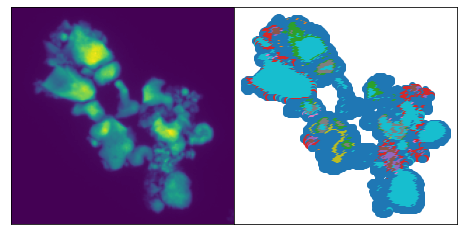

In [110]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[1., 1.])
plt.subplots_adjust(wspace=0.)

ax0 = fig.add_subplot(spec[0])
ax0.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')

ax1 = fig.add_subplot(spec[1])
for key in list(filtered_spectra_dict.keys()):
    spectrum = filtered_spectra_dict[key]
    x, y = key
    ax1.plot(y, -x, c=cdict[key], marker='o')

for ax in fig.get_axes():
    remove_ticks(ax)

plt.show()